# Let's practice fitting transit models to simulated transits

# For our simulated transits, Let's try to use these values as free parameters
# P, T0, RP/RS and b



In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt


import exoplanet as xo

import pandas as pd
import os,sys

In [2]:
#prepare input files

def phasefold(T0,time,period,flux):
    phase=(time- T0 + 0.5*period) % period - 0.5*period
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]

def SMA_AU_from_Period_to_stellar(Period,R_star,M_star):
    #assumes circular orbit
    #using Kepler's third law, calculate SMA
    #solar units
    RS = 6.955*10.0**10.0 #cm, solar radius
    MS = 1.989*10.0**33.0 #g, solar mass

    G = 6.6743*10.0**(-8.0) #cm^3 per g per s^2

    R = R_star*RS
    M = M_star*MS
    P=Period*60.0*24.0*60.0 #in seconds

    #SMA
    SMA_cm = ((G*M*(P**2))/(4*(np.pi**2)))**(1/3)   

    #note R_star is already in solar units so we need to convert to cm using
    # solar radius as a constant
    Stellar_Radius = R #now in cm

    SMA = SMA_cm / Stellar_Radius #now unitless (cm / cm)
    return SMA, SMA_cm

def convert_rp_in_re_to_rs(RP,R_star):
    R_sun=6.955*10**10 # cm
    R_earth=6.378*10**8 #cm
    
    rp_in_rs_units  = (RP/R_star)*(R_earth/R_sun) #in Stellar units
    
    return rp_in_rs_units

def convert_rp_in_rs_to_re(rp_in_rs_units,R_star):
    R_sun=6.955*10**10 # cm
    R_earth=6.378*10**8 #cm
    
    rp_in_re_units = (rp_in_rs_units*R_star)*(R_sun/R_earth) #in Earth units
    
    return rp_in_re_units

def BATMAN_MODEL(RP,T0,P,B,qld, t,y,yerr):
    import batman
    import math
    
    R_sun=6.955*10**10 # cm
    R_earth=6.378*10**8 #cm

    rp = convert_rp_in_re_to_rs(RP,R_star)
    
    cad = np.nanmedian(np.diff(t))
    
    SMA , _ = SMA_AU_from_Period_to_stellar(P,R_star,M_star)
    
    I = math.degrees(np.arccos( (B*R_star) /SMA )) #assuming e=0, w=90
        
    #Initialize Parameters 
    params = batman.TransitParams()      # object to store transit parameters
    params.t0 = T0                       # time of inferior conjunction
    params.per = P                       # orbital period
    params.rp = rp                       # planet radius (in units of stellar radii)
    params.a = SMA                       # semi-major axis (in units of stellar radii)
    params.inc = I                       # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.limb_dark = "quadratic"       # limb darkening model ->"uniform", "linear", "quadratic", "nonlinear", etc.
    params.u = [qld[0],qld[1]]           # limb darkening coefficients

    mt = np.linspace(np.min(t), np.max(t), len(t))       # times at which to calculate light curve
    m = batman.TransitModel(params, mt, exp_time=cad)    # initializes model

    flux = m.light_curve(params)
    flux-= np.nanmedian(y)+1
    
    return mt, flux

In [20]:
def MCMC_transit_fit(input_LC,input_TLS_params, Niters=1000, Ndraws=3000,use_TLS_model='yes'):    
    import time as clock
    import pymc3 as pm
    import corner
    start=clock.time()
    
    # light curve
    t = np.array(input_LC['Time'].to_list())
    y = np.array(input_LC['Flux'].to_list())
    yerr = np.array(input_LC['Flux Error'].to_list())
    
    # TLS best fit parameters
    P = input_TLS_params['Period'].item()
    Perr= input_TLS_params['Period Error'].item()
    T0= input_TLS_params['T0'].item()
    Dur=input_TLS_params['Duration'].item()
    RP=input_TLS_params['Planet Radius'].item()
    RP_RS=input_TLS_params['RP_RS'].item()
    RP_RSerr=input_TLS_params['RP_RSerr'].item()
    
    #stellar params
    qld_a=input_TLS_params['qld_a'].item()
    qld_b=input_TLS_params['qld_b'].item()
    u=[qld_a,qld_b]
    R_star=input_TLS_params['R_star'].item()
    M_star=input_TLS_params['M_star'].item()    
    
    if use_TLS_model=='yes':
        # TLS Model
        TLS_model_time = np.array(input_TLS_model['Time'].to_list())
        TLS_model = np.array(input_TLS_model['Model'].to_list())
    
    #make sure y is zero centered
    y = y - np.nanmedian(y)
#     y = y -1
    
    print('initializing MCMC model')
    with pm.Model() as model:
        
        s=1 # <----for 1 planet model? 

        # The baseline flux
#         mean = pm.Normal("mean", mu=0.0, sd=1.0)
        mean = pm.Normal("mean", mu=np.nanmean(y), sd=np.nanstd(y))

        # The time of a reference transit for each planet
#         t0 = pm.Normal("t0", mu=T0, sd=1.0, shape=s)
        t0 = pm.Normal("t0", mu=T0, sd=Dur/24.0, shape=s)

        # The log period; also tracking the period itself
#         logP = pm.Normal("logP", mu=np.log(P), sd=0.1, shape=s)        
        logP = pm.Normal("logP", mu=np.log(P), sd=Perr, shape=s)
        period = pm.Deterministic("period", pm.math.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u", testval=np.array( [u[0] , u[1]] ))

        #Rp/ RS
        r = pm.Uniform("r", lower=0.01, upper=0.1, shape=s, testval=np.array([RP_RS]))
#         r = pm.Uniform("r", lower=RP_RS-RP_RSerr, upper=RP_RS+RP_RSerr, shape=s, testval=np.array([RP_RS]))
        b = xo.distributions.ImpactParameter("b", ror=r, shape=s, testval=np.random.rand(s))

        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=P, t0=T0, b=b, m_star=M_star,r_star=R_star)
        
        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
        light_curve = pm.math.sum(light_curves, axis=-1) + mean

        # Here we track the value of the model light curve for plotting
        # purposes
        pm.Deterministic("light_curves", light_curves)

        # The likelihood function assuming known Gaussian uncertainty
        pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

        # Fit for the maximum a posteriori parameters given the simuated
        # dataset
        map_soln = xo.optimize(start=model.test_point)
        
        
    fig=plt.figure(figsize=(12,6))
    if use_TLS_model=='yes':
        ax1=fig.add_subplot(311)
        ax2=fig.add_subplot(312)
        ax3=fig.add_subplot(313)
    if use_TLS_model=='no':
        ax1=fig.add_subplot(211)
        ax2=fig.add_subplot(212)
        ax2=fig.add_subplot(212) 



    ax1.plot(t, y, "k.", ms=4, label="data",rasterized=True)
    if use_TLS_model=='yes':
        ax1.plot(TLS_model_time,TLS_model, 'r.',lw=1, label="planet b TLS model",rasterized=True)
    ax1.plot(t, map_soln["light_curves"],'g.', lw=1, label="planet b model",rasterized=True)


    ax1.set_xlim(t.min(), t.max())
    ax1.set_ylabel("relative flux")
    ax1.set_xlabel("time [days]")
    ax1.legend(loc='best',fontsize=10,ncol=3,handletextpad=0.1)
    ax1.set_title("Initialized model as starting point for MCMC")

    pfm,ffm = phasefold(T0,t,P,map_soln["light_curves"])
    pf,ff = phasefold(T0,t,P,y)

    ax2.set_title('Initialized model')
    ax2.plot(24*pf,ff,'k.',markersize=3,label='data',zorder=-10,rasterized=True)
    ax2.plot(24*pfm,ffm,'g.-',label='planet b model',rasterized=True)

    ax2.set_xlim(-5*Dur,5*Dur)
    ax2.set_xlabel('Phase [hours since '+str(np.round(T0,3))+' BTJD]')
    ax2.set_ylabel("Relative Flux")
    ax2.legend(loc='best',fontsize=10,ncol=3,handletextpad=0.1)

    if use_TLS_model=='yes':    
        pfTLS,ffTLS = phasefold(T0,TLS_model_time,P,TLS_model)
        ax3.plot(24*pf,ff,'k.',markersize=3,label='data',zorder=-10,rasterized=True)
        ax3.plot(24*pfTLS,ffTLS,'r.-',label='planet b TLS model',rasterized=True)
        ax3.set_xlim(-3.5*Dur,3.5*Dur)
        ax3.set_xlabel('Phase [hours since '+str(np.round(T0,3))+' BTJD]')
        ax3.set_ylabel("Relative Flux")
        ax3.legend(loc='best',fontsize=10,ncol=3,handletextpad=0.1)

    fig.tight_layout(pad=1)
    fig.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_initial_guess.png',bbox_inches='tight')
    fig.show()
    print(' ')
    if (clock.time()-start)> 60:
        print('Initilization complete. Runtime ',(clock.time()-start)/60,' minutes')
    if (clock.time()-start)< 60:
        print('Initilization complete. Runtime ',(clock.time()-start),' seconds')
    print(' ')
    
    
    # For sampling posteriors from MCMC initial guess
    # Niters = Number of iterations to tune, defaults to 1000. 
    # Samplers adjust the step sizes, scalings or similar during tuning.
    #
    # Ndraws = The number of samples to draw. Defaults to 1000. 
    # The number of tuned samples are discarded by default.
    print('Sampling Posteriors')
    np.random.seed(42)
    with model:
        trace = pm.sample(tune=Niters,draws=Ndraws,start=map_soln,\
            cores=2,chains=2,init="adapt_full",target_accept=0.9)
        
    trace_df=pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])
    
    
    samples = pm.trace_to_dataframe(trace, varnames=["period", "t0","r","b"])
    truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
    
    
    letters='b'
    labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
    labels += ["$T0_{{{0}}} $ [BTJD]".format(i) for i in letters]
    labels += ["$R_{P}/R_{S}$"]
    labels += ["impact param {0}".format(i) for i in letters]
    
    ndim=4
    value1= map_soln["mean"]
    value2=np.mean(samples, axis=0)
    # Make the base corner plot
    figure = corner.corner(samples,labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs=dict(fontsize=10));

    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
#     for i in range(ndim):
#         ax = axes[i, i]
#         ax.axvline(value1[i], color="g")
#         ax.axvline(value2[i], color="r")
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value2[xi], color="r")
            ax.axhline(value2[yi], color="r")
            ax.plot(value2[xi], value2[yi], "sr")

    figure.tight_layout()
    figure.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_MCMC_corner.png',bbox_inches='tight')
    figure.show()
    
    
    print(' ')
    print('Finished!')
    print('')
    
    # Plot the folded data
    # Get the posterior median orbital parameters
    p = np.median(trace["period"])
    t0 = np.median(trace["t0"])


    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p



    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(111)
    ax1.plot(24*x_fold, y, ".k", label="data", zorder=-1000)


    # Plot the folded models
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < Dur*24]
    pred = trace["light_curves"][:, inds, 0]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    ax1.plot(24*x_fold[inds], pred[1], color="C1", label="model")
    art = ax1.fill_between(24*x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.5f} +/- {1:.5f} d".format(np.mean(trace["period"]), np.std(trace["period"]))
    ax1.annotate(txt,(0, 0),xycoords="axes fraction",xytext=(5, 5),\
        textcoords="offset points", ha="left",va="bottom",fontsize=12)

#     TLSx_fold = (TLS_model_time - t0 + 0.5 * p) % p - 0.5 * p
#     TLSinds = np.argsort(TLSx_fold)
#     ax1.plot(24*TLSx_fold[TLSinds],TLS_model[TLSinds],'r.-',label='TLS')

    ax1.legend(fontsize=10, loc=4,ncol=3)
    ax1.set_xlabel("Phase [hours since "+str(np.round(t0,4))+"]")
    ax1.set_ylabel("Relative Flux")
    ax1.set_xlim(-3*Dur,3*Dur)
    ax1.set_title('TIC '+str(ID)+' Sector '+str(Sector)+' best fit MCMC model')
    fig.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_bestfit_MCMC_model.png',bbox_inches='tight')
    fig.show()
    
    
    
    if (clock.time()-start)> 60:
        print('Total runtime ',(clock.time()-start)/60,' minutes')
    if (clock.time()-start)< 60:
        print('Total runtime ',(clock.time()-start),' seconds')
    print(' ')
    
    return samples, trace

In [15]:
def Transit_duration(Period, SMA_cm, R_star, R_planet_RE):
    RE = 6.378*10.0**8 #cm
    RS = 6.955 *10.0**10 #cm    
    A = Period/np.pi #in days
    B =(R_star*RS +R_planet_RE*RE)/ SMA_cm #in cm
    
    T_dur = A*np.arcsin(B) #in days
    return T_dur

# Let's simulated a TESS LC with transits

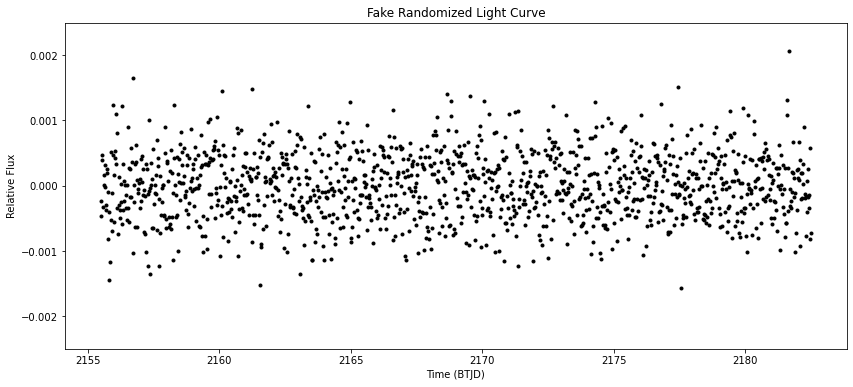

In [16]:
ID = 123456789
Sector=0
path = os.getcwd()+'/'



fs=10 #fontsize for text in figures

ndays = 27 #days
cadence= 30/(60*24) # 30 minute cadence in days ~ 0.021
pts_per_day = int(np.round(((1/cadence))+1,1)) 


scatter_frac = 500/1e6  # add 500 ppm scatter to data to make it somewhat realistic

start=0.0
stop=ndays
stepsize=ndays*pts_per_day

t = 2459155.5 + np.linspace(start, stop, stepsize) - 2457000  #in BTJD; 2459155.5 = 11/2/2020

#let's add random noise to our flux "measurements"
y = np.random.randn(t.size) * scatter_frac #+1 if you want it to be centered on 1.0
yerr = np.ones_like(y) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.gca().ticklabel_format(useOffset=False)
plt.plot(t ,y,marker='.',color='black',linestyle='none')
plt.xlabel("Time (BTJD)")
plt.ylabel("Relative Flux")
plt.title("Fake Randomized Light Curve")
plt.ylim(0.9975-1,1.0025-1)
plt.show()

In [17]:
# Let's say this is a Mdwarf star
M_star = 0.25 #in solar masses
R_star = 0.25 #in solar radii
qld = [0.3,0.3] #quadratic limb darkening parameters

R_sun=6.955*10**10 # cm
R_earth=6.378*10**8 #cm

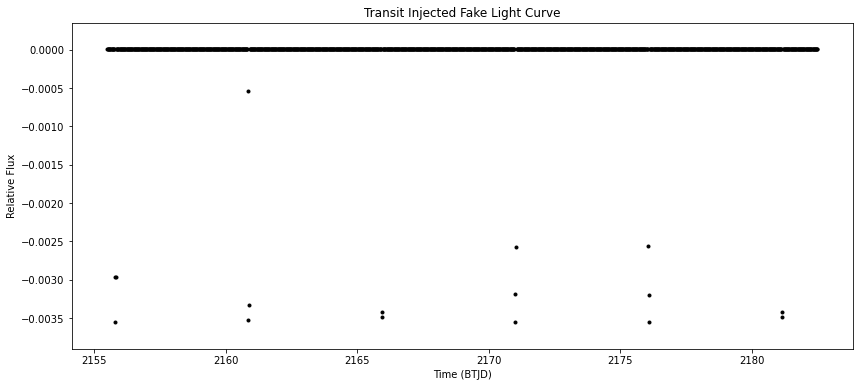

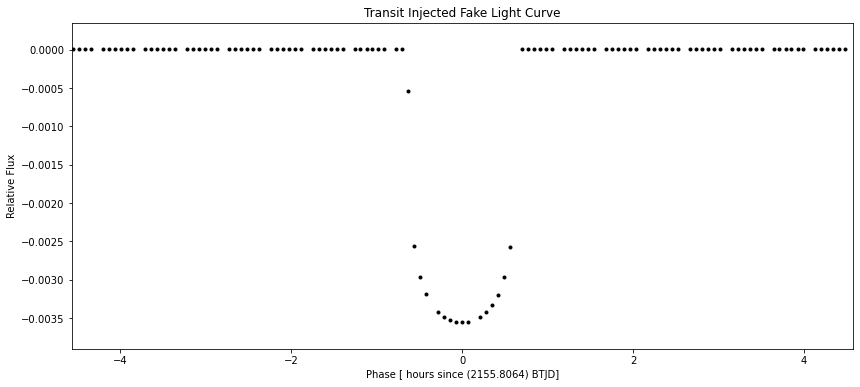

In [18]:
#prepare input parameters

#randomly sample a time from within 1st 5 days of data as transit time
import random
T0= float(random.sample(list(t[(2155<t) & (t<2160)]),1)[0]) #BTJD

#pick between 1 - 27/3 days to get min 3 transits
LC_duration = float(np.max(t) - np.min(t))
P = float(random.uniform(1, LC_duration/3)) #days

#let's say this error is pretty accurate down to 15 minutes
Perr=float(15/(60*24) )# days

#let's select our planet size
RP= float(1.5) #in Earth Radii
RPerr=float(0.25) #in Earth Radii

Depth= float((RP*R_earth/(R_star*R_sun))**2 )#unitless
RP_RS =float(np.sqrt(Depth)) #unitless
RP_RSerr = 0.1 #unitless

#from our random Period, let's calculate semi-major axis (SMA)
SMA,SMA_cm = SMA_AU_from_Period_to_stellar(P, R_star, M_star) #scaled SMA (unitless) and in cm

#let's calculate transit duration from P, RS, RP and SMA (assuming circular orbit)
Dur = 24*float(Transit_duration(P, SMA_cm, R_star,RP)) #in hours


# other assumptions for a circular transit
B=0
e=0
w=90


# With our transit parameters defined, let's simulate our transits with BATMAN

model_time,model_flux = BATMAN_MODEL(RP,T0,P,B,qld, t,y,yerr)



plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(model_time,model_flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (BTJD)")
plt.ylabel("Relative Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(np.min(model_flux)-np.nanstd(model_flux),np.max(model_flux)+np.nanstd(model_flux))
plt.show()


pfm,ffm = phasefold(T0,model_time,P,model_flux)

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(24*pfm,ffm,marker='.',color='black',linestyle='none')
plt.xlabel("Phase [ hours since ("+str(np.round(T0,4))+") BTJD]")
plt.ylabel("Relative Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(np.min(model_flux)-np.nanstd(model_flux),np.max(model_flux)+np.nanstd(model_flux))
plt.xlim(-3.5*Dur,3.5*Dur)
plt.show()


input_LC = pd.DataFrame({'Time':model_time,'Flux':model_flux,'Flux Error':yerr})
input_Transit_params = pd.DataFrame({'Period':P,'Period Error':Perr,'T0':T0,'Duration':Dur,'Planet Radius':RP,'RP_RS':RP_RS,'RP_RSerr':RP_RSerr,'qld_a':qld[0],'qld_b':qld[1],'R_star':R_star,'M_star':M_star},index=[0])
cad = cadence

initializing MCMC model


optimizing logp for variables: [b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -50118.11658075534 -> 8844.57148936238
<ipython-input-20-0b9878efa4ed>:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=fig.add_subplot(212)
<ipython-input-20-0b9878efa4ed>:129: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/Dax/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an e

 
Initilization complete. Runtime  7.0568459033966064  seconds
 
Sampling Posteriors


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 151 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
/Users/Dax/opt/anaconda3/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
<ipython-input-20-0b9878efa4ed>:187: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


 
Finished!



<ipython-input-20-0b9878efa4ed>:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Total runtime  2.8725068012873334  minutes
 


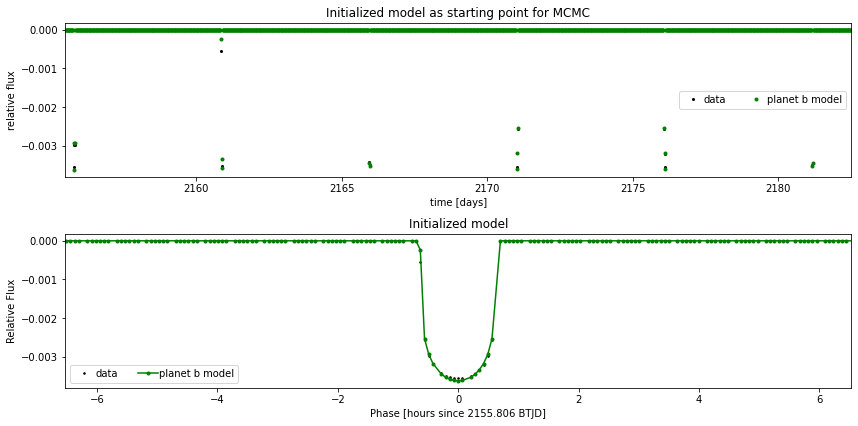

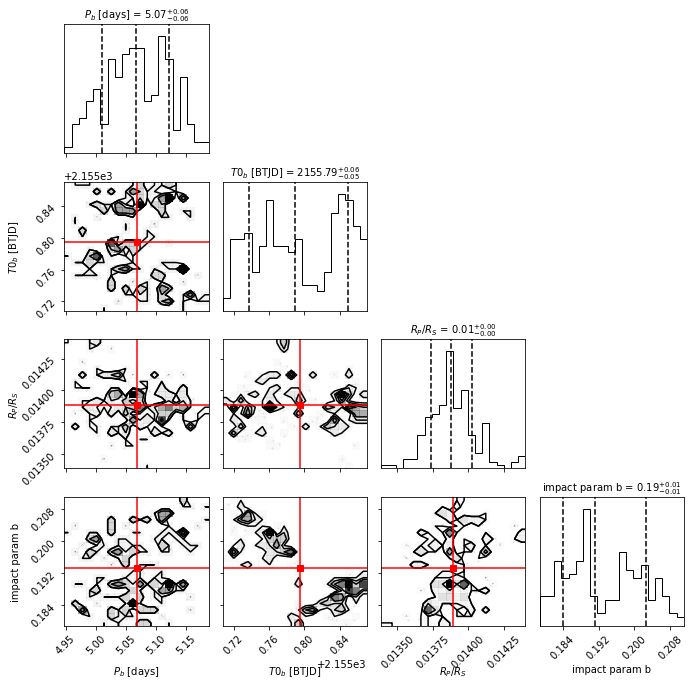

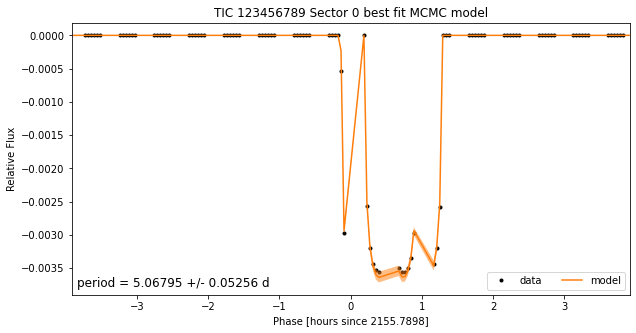

In [21]:
samples, trace = MCMC_transit_fit(input_LC,input_Transit_params, Niters=100, Ndraws=100,use_TLS_model='no')

In [23]:
print(P,T0,RP_RS,B)

5.070893239192048 2155.8063540090807 0.055022286125089866 0


# Final answers are pretty close!

# more iterations and draws should lead to better estimation of injected values. Give it a try!